# Identifying Users Using Topological Data Analysis

## 1. Introduction

In this notebook we calculate persistence diagrams for all the test
subjects in the study, and then try to identify each subject using the bottleneck
distance of their respective persistence diagrams

## 2. Approach

We use the machine learning library [scikit-learn](https://scikit-learn.org/stable/)
to train a model to identify test subjects based on the
bottleneck distances of the persistance diagrams of their typing data. Next, we find an
optimal set of hyperparameters for our model. Finally, we introduce new typing data samples
and check how accurately it matches each new sample to its corresponding test subject.

### 2.1. Setup

First we load the typing data into a [pandas](https://pandas.pydata.org) `DataFrame` to facilitate the processing of the data. As we can see, there a little over 20,000 rows in our `DataFrame`. Each test subject has 8 typing sessions consisting of 50 repititions.

In [1]:
import pandas as pd

typing_data = pd.read_csv('data/DSL-StrongPasswordData.csv',
                          # declare type of 'subject' column
                          dtype = {'subject' : 'string'},
                          index_col = ['subject', 'sessionIndex', 'rep'])
typing_data.describe()

,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,UD.i.e,H.e,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
count,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,...,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000
mean,0.093379,0.264148,0.170769,0.085727,0.169085,0.083358,0.081565,0.159372,0.077806,0.089138,...,0.106259,0.150670,0.044411,0.089899,0.202630,0.112731,0.095589,0.321847,0.226259,0.088306
std,0.029626,0.220534,0.226836,0.027424,0.123546,0.125755,0.026887,0.226928,0.228512,0.030635,...,0.038828,0.107422,0.105197,0.030738,0.150191,0.159571,0.028348,0.225389,0.230759,0.027452
min,0.001400,0.018700,-0.235800,0.009300,0.001100,-0.162100,0.003200,0.001400,-0.160000,0.002100,...,0.004000,0.001100,-0.235500,0.003700,0.001300,-0.175800,0.003700,0.008300,-0.124500,0.002900
25%,0.074400,0.146900,0.049800,0.066000,0.113600,0.027200,0.062000,0.089300,0.007400,0.068600,...,0.082100,0.096100,-0.009000,0.067300,0.127600,0.023500,0.077400,0.210000,0.114100,0.069900
50%,0.089500,0.205950,0.108700,0.081000,0.140400,0.057800,0.077100,0.120900,0.041200,0.083400,...,0.101900,0.125000,0.022700,0.085300,0.172500,0.095500,0.093700,0.263000,0.160300,0.085500
75%,0.107900,0.306450,0.212400,0.099800,0.183900,0.096400,0.096900,0.173100,0.093400,0.102700,...,0.122300,0.174600,0.068900,0.107900,0.228800,0.145700,0.111100,0.350200,0.255100,0.103700
max,0.376100,12.506100,12.451700,0.241100,4.919700,4.799900,0.331200,25.987300,25.915800,0.325400,...,2.035300,3.327800,2.524200,0.357700,4.025200,3.978200,0.340700,5.883600,5.836400,0.265100


### 2.2 Prerocessing the Data

Now we need to process the data so that we can generate a persistence diagram for each typing session. To do this, we group the typing data by test subject and store it in a list. We also create list that contains the corresponding labels. In order to get better results, we shuffle the data before splitting each test subject's typing data and labels into the 8 sessions.

In [2]:
from modules.helpers import subject_labels_in_range, TypingDataSplit

In [3]:
# Generate labels and group typing data by subject
labels = subject_labels_in_range(2, 57)
typing_data_grouped_by_subject = [ typing_data.loc[label].values for label in labels ]

# Shuffle data and split into 8 sessions
splitter = TypingDataSplit(shuffle=True, random_state=1, n_splits=8)
split_data, split_labels = splitter.split(typing_data_grouped_by_subject, labels)

output_string = f"Split and shuffled data has length {len(split_data)}, which is equal to\n" + \
                "51 (number of test subjects) times 8 (number of typing sessions per subject)."
print(output_string)

Split and shuffled data has length 408, which is equal to
51 (number of test subjects) times 8 (number of typing sessions per subject).


### 2.3 Calculating Persistence Diagrams for Training and Testing

Now, we use our preprocessed data to generate a persistence diagram for each typing session. We then extract
the persistence intervals in the specified dimension (`dimension` variable below) and use scikit-learn's
`train_test_split` to generate our training and testing data. We set `random_state` equal to an integer for
reproducibility.

In [4]:
import gudhi                 as gd
from sklearn.model_selection import train_test_split
from modules.helpers         import persistence_in_dimension

In [5]:
diagrams = [] # list to store persistence diagrams
max_e    = 3  # maximum edge length for Vietoris-Rips complex
max_dim  = 3  # maximum dimension for simplex tree

for points in split_data:
    simplex_tree = gd.RipsComplex(points=points, max_edge_length=max_e).create_simplex_tree(max_dimension = max_dim)
    diagrams.append(simplex_tree.persistence())

In [6]:
dimension = 0 # dimension of persistence intervals

# Extract persistence intervals from persistence diagrams
X = list(map(lambda x: persistence_in_dimension(x,dimension), diagrams))

X_train, X_test, y_train, y_test = train_test_split(X, split_labels,
                                                    stratify=split_labels,
                                                    train_size=0.75,
                                                    random_state=0)

Below we have the first four diagrams for subject `s002`. As we can see, they vary quite a bit,
but notice that the first and fourth diagrams are quite similar.

usetex mode requires TeX.


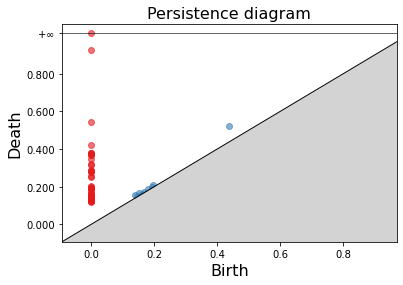

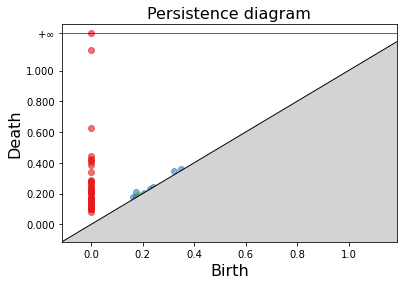

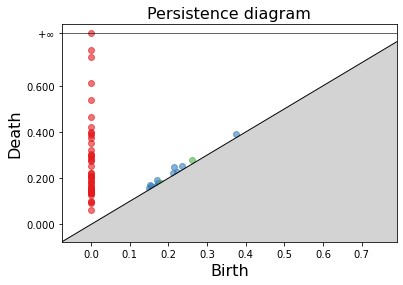

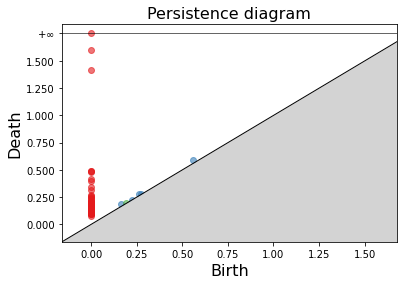

In [7]:
for diagram in diagrams[:4]:
    gd.plot_persistence_diagram(diagram)

### 2.4 Training and Optimizing the Model

Next, we optimize our hyperparameters using a grid search algorithm and train our model using the Bottleneck distance metric.
First, we only keep the finite from our persistence intervals using the `DiagramSelector`. Then we vary the `epsilon` (which
here represents the absolute error tolerated on the distance), `n_neighbors` (which represents the number of neighbors our
K Nearest Neighbors Classifier uses), `weights` (which represent the how the nearest neighbors are weighted), and `p` (which
represents the power for the Minkowski metric, 1 for Manhattan distance and 2 for Euclidean distance).

In [8]:
import gudhi.representations
import numpy                 as np
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import MinMaxScaler
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [9]:
pipe = Pipeline([("Separator", gd.representations.DiagramSelector(use=True, limit=np.inf, point_type="finite")),
                 ("Scaler",    gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),   
                 ("TDA",       gd.representations.BottleneckDistance()),
                 ("Estimator", KNeighborsClassifier(metric="precomputed"))])

params = [
    {
        "Scaler__use":            [False],
        "TDA__epsilon":           [1e-3, 0.01, 0, 0.1],
        "Estimator__n_neighbors": [3],
        "Estimator__weights":     ['uniform', 'distance'],
        "Estimator__p":           [1, 2]
    }
]

In [10]:
model = GridSearchCV(pipe, params, n_jobs=-1, scoring='accuracy', cv=3)
model.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Separator', DiagramSelector(use=True)),
                                       ('Scaler',
                                        DiagramScaler(scalers=[([0, 1],
                                                                MinMaxScaler())])),
                                       ('TDA', BottleneckDistance()),
                                       ('Estimator',
                                        KNeighborsClassifier(metric='precomputed'))]),
             n_jobs=-1,
             param_grid=[{'Estimator__n_neighbors': [3], 'Estimator__p': [1, 2],
                          'Estimator__weights': ['uniform', 'distance'],
                          'Scaler__use': [False],
                          'TDA__epsilon': [0.001, 0.01, 0, 0.1]}],
             scoring='accuracy')

Below is the optimized hyperparameter set found by our grid search algorithm.

In [11]:
model.best_params_

{'Estimator__n_neighbors': 3,
 'Estimator__p': 1,
 'Estimator__weights': 'distance',
 'Scaler__use': False,
 'TDA__epsilon': 0.001}

## 3. Results and Analysis

Using the Bottleneck distance metric, our model correctly
matched typing data it had already seen to its corresponding test subject with 100% accuracy.
However, when we introduced new typing data, its accuracy dropped down to
about 10%.

In [12]:
print(f"Bottleneck distance trainig accuracy\t= {model.score(X_train, y_train) * 100}%")
print(f"Bottleneck distance prediction accuracy\t= {model.score(X_test, y_test) * 100}%")

Bottleneck distance trainig accuracy	= 100.0%
Bottleneck distance prediction accuracy	= 9.803921568627452%


## 4. Discussion and Future Work

For Topological Data Analysis, our dataset was
was on the small side, with only 50 data points per persistence diagram. It is likely
that we would have achieved better results with more data points per diagram (400 and up).
Also, since our machine learning experience is very limited, we may have been able to
achieve better results by changing other paramaters.

There are other tools in Topological Data Analysis besides the Bottleneck
distance that could lead to better results. For example, below we use the Persistence
Landscape, Persistence Image, Slicced Wasserstein Kernel, and Persistence Weighted Gaussian Kernel.
With minimal tuning, we achieved close to 30% accuracy using the Persistence Image instead of
the Bottleneck distance.

In [13]:
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier

In [14]:
params = [
    {
        "Scaler__use":                  [False],
        "TDA__epsilon":                 [1e-3, 0.01, 0, 0.1],
        "Estimator__n_neighbors":       [3],
        "Estimator__weights":           ['uniform', 'distance'],
        "Estimator__p":                 [1, 2]
    },
    {
        "Scaler__use":                  [True],
        "TDA":                          [gd.representations.PersistenceImage()],
        "TDA__resolution":              [[5, 5], [10, 10], [20, 20], [50, 50]],
        "TDA__bandwidth":               [0.01, 0.1, 1, 10],
        "Estimator":                    [SVC()]
    },
    {
        "Scaler__use":                  [True],
        "TDA":                          [gd.representations.Landscape()], 
        "TDA__num_landscapes":          [3,4,5,10],
        "TDA__resolution":              [50, 100, 150],
        "Estimator":                    [RandomForestClassifier()],
        "Estimator__n_estimators":      [50, 100, 150],
        "Estimator__criterion":         ['gini', 'entropy'],
        "Estimator__min_samples_split": [0.001, 0.1, 2, 4],
        "Estimator__random_state":      [0]
    },
    {
        "Scaler__use":                  [False],
        "TDA":                          [gd.representations.SlicedWassersteinKernel()], 
        "TDA__bandwidth":               [0.1, 1.0, 10],
        "TDA__num_directions":          [10, 20],
        "Estimator":                    [SVC(kernel="precomputed", gamma="auto")]
    },
    {
        "Scaler__use":                  [False],
        "TDA":                          [gd.representations.PersistenceWeightedGaussianKernel()], 
        "TDA__bandwidth":               [1, 0.1, 0.01],
        "TDA__weight":                  [lambda x: np.arctan(x[1]-x[0])], 
        "Estimator":                    [SVC(kernel="precomputed", gamma="auto")]
    }
]

In [15]:
model = GridSearchCV(pipe, params, n_jobs=-1, scoring='accuracy', cv=3)
model.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Separator', DiagramSelector(use=True)),
                                       ('Scaler',
                                        DiagramScaler(scalers=[([0, 1],
                                                                MinMaxScaler())])),
                                       ('TDA', BottleneckDistance()),
                                       ('Estimator',
                                        KNeighborsClassifier(metric='precomputed'))]),
             n_jobs=-1,
             param_grid=[{'Estimator__n_neighbors': [3], 'Estimator__p': [1, 2],
                          'Estimator__weights': ['uniform', 'distance'],
                          'S...
                                            kernel='precomputed')],
                          'Scaler__use': [False],
                          'TDA': [SlicedWassersteinKernel()],
                          'TDA__bandwidth': [0.1, 1.0, 10],
                          'TDA__nu

In [16]:
model.best_params_

{'Estimator': SVC(),
 'Scaler__use': True,
 'TDA': PersistenceImage(bandwidth=0.01, resolution=[50, 50]),
 'TDA__bandwidth': 0.01,
 'TDA__resolution': [50, 50]}

In [18]:
print(f"Prediction accuracy = {model.score(X_test, y_test) * 100}%")

Prediction accuracy = 28.431372549019606%
